# MobileNetV3肺结核检测

本项目旨在利用深度学习技术，基于MindSpore框架构建一个高效的肺结核检测模型。通过使用MobileNetV3作为核心网络架构，我们能够在保证高精度的同时，显著降低计算资源的需求，从而实现快速、准确的肺结核诊断。该项目的目标是为医疗行业提供一种低成本、高性能的解决方案，助力肺结核的早期筛查与诊断。


## 环境准备
1.安装指定版本的MindSpore：

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

2.验证已安装的MindSpore版本：


In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


3.安装kagglehub库与seaborn库


In [3]:
!pip install kagglehub
!pip install seaborn

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple/
Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple/


4.数据集下载与存放

In [4]:
import kagglehub

path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

100%|██████████| 663M/663M [01:18<00:00, 8.84MB/s] 

Extracting files...


Path to dataset files: /home/mindspore/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3


In [5]:
!mkdir dataset && cp -r /home/mindspore/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database/Normal ./dataset && cp -r /home/mindspore/.cache/kagglehub/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/versions/3/TB_Chest_Radiography_Database/Tuberculosis ./dataset

下载解压完成后存放格式如下  
.dataset/  
    ├── Normal/  
    └── Tuberculosis/

## 一.激活函数构建
### hsigmoid 计算公式

$$
h\text{-}sigmoid(x) = \frac{\text{ReLU6}(x + 3)}{6}
$$

### hswish 计算公式

$$
h\text{-}swish(x) = x \cdot h\text{-}sigmoid(x)
$$
![%DISPLAY_TITLE%](https://s1.imagehub.cc/images/2025/03/31/314ffd2a05d4d90cd13e3dbb447a17ff.png)

In [6]:
%%capture captured_output
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore as ms

class HSigmoid(nn.Cell):
    def __init__(self):
        super(HSigmoid, self).__init__()
        self.relu6 = nn.ReLU6()

    def construct(self, x):
        return self.relu6(x + 3.) / 6.

class HSwish(nn.Cell):
    def __init__(self):
        super(HSwish, self).__init__()
        self.hsigmoid = HSigmoid()

    def construct(self, x):
        return x * self.hsigmoid(x)

## 二.SE 模块

SE 模块（Squeeze-and-Excitation Module）通过显式建模通道之间的依赖关系，动态调整每个通道的重要性权重。
![%DISPLAY_TITLE%](https://s1.imagehub.cc/images/2025/03/31/23323bd436d6e2860ae880f2926ae56f.png)

In [7]:
class SEBlock(nn.Cell):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = ops.ReduceMean(keep_dims=True)
        self.fc1 = nn.Dense(in_channels, in_channels // reduction, has_bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Dense(in_channels // reduction, in_channels, has_bias=True)
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        out = self.avg_pool(x, (2, 3))  # 全局平均池化，将空间维度压缩为 1x1
        out = out.view(out.shape[0], -1)  # 展平
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.shape[0], out.shape[1], 1, 1)  # 恢复形状
        return x * out

## 三.MobileNetV3 中的倒残差结构（Inverted Residual Block）

倒残差结构（Inverted Residual Block）是 MobileNetV3 的核心组成部分，继承自 MobileNetV2，并在此基础上进行了优化和改进。其主要特点是通过扩展（expand）、深度可分离卷积（depthwise separable convolution）和压缩（squeeze）来实现高效的特征提取。

![%DISPLAY_TITLE%](https://s1.imagehub.cc/images/2025/03/31/67a426a83eb938a8a96c16706792b5f3.png)



In [8]:
class Bottleneck(nn.Cell):
    def __init__(self, in_channels, out_channels, exp_size, kernel_size, stride, use_se, use_hs):
        super(Bottleneck, self).__init__()
        self.use_se = use_se
        self.use_hs = use_hs
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels, exp_size, kernel_size=1, has_bias=False)
        self.bn1 = nn.BatchNorm2d(exp_size)
        self.conv2 = nn.Conv2d(exp_size, exp_size, kernel_size=kernel_size, stride=stride,
                           pad_mode='same', group=exp_size, has_bias=False)
        self.bn2 = nn.BatchNorm2d(exp_size)
        self.conv3 = nn.Conv2d(exp_size, out_channels, kernel_size=1, has_bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels) if use_se else None
        self.relu = nn.ReLU()
        self.hs = nn.HSwish()
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, has_bias=False) if in_channels!= out_channels else None
        self.bn_identity = nn.BatchNorm2d(out_channels) if in_channels!= out_channels else None

    def construct(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        if self.use_hs:
            out = self.hs(out)
        else:
            out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_hs:
            out = self.hs(out)
        else:
            out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.use_se:
            out = self.se(out)
        if self.identity is not None:
            identity = self.identity(x)
            identity = self.bn_identity(identity)
        else:
            identity = x
        out = out + identity  # 残差连接
        if self.use_hs:
            out = self.hs(out)
        else:
            out = self.relu(out)
        return out

## 四.MobileNetV3 主干网络

MobileNetV3 是一种轻量级卷积神经网络，专为移动设备设计，具有高效性和高性能的特点。其主干网络由多个 **倒残差块（Inverted Residual Blocks）** 和其他优化模块组成。


### MobileNetV3 主干网络的结构

以下是 MobileNetV3 主干网络的典型结构（以 MobileNetV3-Large 为例）：

| **Layer**               | **Operator**                     | **Output Size**       | **#Channels** |
|--------------------------|----------------------------------|-----------------------|---------------|
| Initial Conv             | Conv 3x3, stride 2, h-swish      | 112 x 112            | 16            |
| Bottleneck Block 1       | Inverted Residual, SE, h-swish   | 112 x 112            | 16 → 16       |
| Bottleneck Block 2       | Inverted Residual, SE, h-swish   | 56 x 56              | 16 → 24       |
| Bottleneck Block 3       | Inverted Residual, SE, h-swish   | 56 x 56              | 24 → 24       |
| Bottleneck Block 4       | Inverted Residual, SE, h-swish   | 28 x 28              | 24 → 40       |
| Bottleneck Block 5       | Inverted Residual, SE, h-swish   | 28 x 28              | 40 → 40       |
| Bottleneck Block 6       | Inverted Residual, SE, h-swish   | 14 x 14              | 40 → 80       |
| Bottleneck Block 7       | Inverted Residual, SE, h-swish   | 14 x 14              | 80 → 80       |
| Bottleneck Block 8       | Inverted Residual, SE, h-swish   | 14 x 14              | 80 → 80       |
| Bottleneck Block 9       | Inverted Residual, SE, h-swish   | 14 x 14              | 80 → 80       |
| Bottleneck Block 10      | Inverted Residual, SE, h-swish   | 7 x 7                | 80 → 112      |
| Bottleneck Block 11      | Inverted Residual, SE, h-swish   | 7 x 7                | 112 → 112     |
| Bottleneck Block 12      | Inverted Residual, SE, h-swish   | 7 x 7                | 112 → 160     |
| Bottleneck Block 13      | Inverted Residual, SE, h-swish   | 7 x 7                | 160 → 160     |
| Final Conv               | Conv 1x1, h-swish                | 7 x 7                | 160 → 960     |
| Global Average Pooling   | GAP                              | 1 x 1                | 960           |
| Fully Connected          | FC, Softmax                      | Classification Output| #Classes      |


### MobileNetV3-Small 和 MobileNetV3-Large 的区别

| **Feature**              | **MobileNetV3-Small**            | **MobileNetV3-Large** |
|--------------------------|----------------------------------|-----------------------|
| 输入分辨率               | 较低（如 224x224 或更低）        | 较高（如 224x224 或更高） |
| 倒残差块数量             | 较少                             | 较多                  |
| 扩展因子                 | 较小（节省计算资源）             | 较大（提高精度）      |
| 参数量                   | 约 2.9M                          | 约 5.4M               |
| 计算量（FLOPs）          | 约 0.055B                        | 约 0.217B             |



In [9]:
class MobileNetV3(nn.Cell):
    def __init__(self, num_classes=2, mode='large', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        self.cfgs = []
        if mode == 'large':
            self.cfgs = [
                # k, exp, c,  se,     nl,  s
                [3, 16, 16, False, 'RE', 1],
                [3, 64, 24, False, 'RE', 2],
                [3, 72, 24, False, 'RE', 1],
                [5, 72, 40, True, 'RE', 2],
                [5, 120, 40, True, 'RE', 1],
                [5, 120, 40, True, 'RE', 1],
                [3, 240, 80, False, 'HS', 2],
                [3, 200, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 184, 80, False, 'HS', 1],
                [3, 480, 112, True, 'HS', 1],
                [3, 672, 112, True, 'HS', 1],
                [5, 672, 160, True, 'HS', 2],
                [5, 960, 160, True, 'HS', 1],
                [5, 960, 160, True, 'HS', 1],
            ]
            self.last_channels = 960
        else:  # mode == 'small'
            self.cfgs = [
                # k, exp, c,  se,     nl,  s
                [3, 16, 16, True, 'RE', 2],
                [3, 72, 24, False, 'RE', 2],
                [3, 88, 24, False, 'RE', 1],
                [5, 96, 40, True, 'HS', 2],
                [5, 240, 40, True, 'HS', 1],
                [5, 240, 40, True, 'HS', 1],
                [5, 120, 48, True, 'HS', 1],
                [5, 144, 48, True, 'HS', 1],
                [5, 288, 96, True, 'HS', 2],
                [5, 576, 96, True, 'HS', 1],
                [5, 576, 96, True, 'HS', 1],
            ]
            self.last_channels = 576
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = []
        layers.append(nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, pad_mode='pad', has_bias=False))
        layers.append(nn.BatchNorm2d(input_channel))
        if mode == 'large':
            layers.append(nn.HSwish())
        else:
            layers.append(nn.ReLU())
        for k, exp, c, se, nl, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_channel = _make_divisible(exp * width_mult, 8)
            use_hs = nl == 'HS'
            use_se = se
            layers.append(Bottleneck(input_channel, output_channel, exp_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        last_channel = _make_divisible(self.last_channels * width_mult, 8) if width_mult > 1.0 else self.last_channels
        layers.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, has_bias=False))
        layers.append(nn.BatchNorm2d(last_channel))
        if mode == 'large':
            layers.append(nn.HSwish())
        else:
            layers.append(nn.ReLU())
        self.features = nn.SequentialCell(layers)
        self.avgpool = ops.ReduceMean(keep_dims=True)
        self.classifier = nn.Dense(last_channel, num_classes)

    def construct(self, x):
        x = self.features(x)
        x = self.avgpool(x, (2, 3))
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

## 五、网络测试
* 打印出我们的网络结构并且创建一个张量对网络进行测试
* 使用numpy的random.randn函数生成一个形状为(1, 3, 224, 224)的随机数组，数组中的元素服从标准正态分布。
* 这里的(1, 3, 224, 224)表示一个批量大小为 1、通道数为 3、高度和宽度均为 224 的图像数据。
* 通过测试查看我们的网络结构是否正确，参数是否正确。

In [10]:
import numpy as np
from mindspore import Tensor
# 实例化模型
model = MobileNetV3(num_classes=2, mode='large', width_mult=1.0)

# 打印模型结构
#print("模型结构：")
#print(model)

# 测试模型是否可用
dummy_input = Tensor(np.random.randn(1, 3, 224, 224).astype(np.float32))
try:
    output = model(dummy_input)
    print("模型输出形状：", output.shape)
    print("模型测试成功！")
except Exception as e:
    print("模型测试失败，错误信息：", str(e))

..模型输出形状： (1, 2)
模型测试成功！


## 六、数据划分
* 划分数据集，将原本的数据集格式  
.dataset/  
├── Normal/  
└── Tuberculosis/  
* 划分为  
.dataset/  
├── train/  
 |   ├── Normal/  
 |   └── Tuberculosis/  
├── test  
 |   ├── Normal/  
 |   └── Tuberculosis/  
└── val  
    ├── Normal/  
    └── Tuberculosis/  

In [11]:
import mindspore.dataset.vision.c_transforms as c_vision
import mindspore.dataset.transforms.c_transforms as c_transforms
from mindspore.dataset import ImageFolderDataset
import mindspore.nn as nn
from mindspore.train import Model, LossMonitor, Accuracy
import os
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, auc, precision_recall_curve, classification_report
import numpy as np
from tqdm import tqdm 
import seaborn as sns
import mindspore.ops as ops
import mindspore as ms

def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    normal_dir = os.path.join(data_dir, 'Normal')
    tuberculosis_dir = os.path.join(data_dir, 'Tuberculosis')
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # 创建目录
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'Tuberculosis'), exist_ok=True)

    # 获取文件列表
    normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)]
    tuberculosis_files = [os.path.join(tuberculosis_dir, f) for f in os.listdir(tuberculosis_dir)]

    # 打乱文件列表
    random.shuffle(normal_files)
    random.shuffle(tuberculosis_files)

    def split_files(files, train_size, val_size):
        train_files = files[:train_size]
        val_files = files[train_size:train_size + val_size]
        test_files = files[train_size + val_size:]
        return train_files, val_files, test_files

    # 计算划分数量
    num_normal = len(normal_files)
    num_tuberculosis = len(tuberculosis_files)
    train_normal_size = int(num_normal * train_ratio)
    val_normal_size = int(num_normal * val_ratio)
    test_normal_size = num_normal - train_normal_size - val_normal_size
    train_tuberculosis_size = int(num_tuberculosis * train_ratio)
    val_tuberculosis_size = int(num_tuberculosis * val_ratio)
    test_tuberculosis_size = num_tuberculosis - train_tuberculosis_size - val_tuberculosis_size

    # 划分正常图像
    train_normal, val_normal, test_normal = split_files(normal_files, train_normal_size, val_normal_size)
    # 划分肺结核图像
    train_tuberculosis, val_tuberculosis, test_tuberculosis = split_files(tuberculosis_files, train_tuberculosis_size, val_tuberculosis_size)

    def copy_files(files, dst_dir):
        for file in files:
            shutil.copy(file, dst_dir)

    # 复制正常图像
    copy_files(train_normal, os.path.join(train_dir, 'Normal'))
    copy_files(val_normal, os.path.join(val_dir, 'Normal'))
    copy_files(test_normal, os.path.join(test_dir, 'Normal'))
    # 复制肺结核图像
    copy_files(train_tuberculosis, os.path.join(train_dir, 'Tuberculosis'))
    copy_files(val_tuberculosis, os.path.join(val_dir, 'Tuberculosis'))
    copy_files(test_tuberculosis, os.path.join(test_dir, 'Tuberculosis'))

## 七、数据预处理与数据载入
这段代码定义了两个函数 `preprocess_dataset` 和 `load_datasets`，用于加载和预处理图像数据明。


In [12]:
def preprocess_dataset(dataset_dir, batch_size=32, image_size=(512, 512), train=True):
    # 加载数据集
    dataset = ImageFolderDataset(dataset_dir, num_parallel_workers=4)
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            c_vision.RandomCropDecodeResize(image_size),
            c_vision.RandomHorizontalFlip(prob=0.5),
            c_vision.Normalize(mean=mean, std=std),
            c_vision.HWC2CHW()
        ]
    else:
        trans = [
            c_vision.Decode(),
            c_vision.Resize(image_size),
            c_vision.CenterCrop(image_size),
            c_vision.Normalize(mean=mean, std=std),
            c_vision.HWC2CHW()
        ]
    type_cast_op = c_transforms.TypeCast(ms.int32)
    dataset = dataset.map(operations=trans, input_columns=["image"], num_parallel_workers=4)
    dataset = dataset.map(operations=type_cast_op, input_columns=["label"], num_parallel_workers=4)
    dataset = dataset.batch(batch_size)
    return dataset


def load_datasets(batch_size=32):
    train_dataset = preprocess_dataset("dataset/train", batch_size=batch_size, image_size=(512, 512), train=True)
    val_dataset = preprocess_dataset("dataset/val", batch_size=batch_size, image_size=(512, 512), train=False)
    test_dataset = preprocess_dataset("dataset/test", batch_size=batch_size, image_size=(512, 512), train=False)
    return train_dataset, val_dataset, test_dataset

## 八、绘制模型评估图


In [13]:
def generate_evaluation_plots(model_path, test_dataset, save_dir):
    # 加载模型
    model = MobileNetV3(num_classes=2)
    ms.load_checkpoint(model_path, model, strict_load=True)
    model.set_train(False)  
    
    # 检查测试数据
    if test_dataset.get_dataset_size() == 0:
        raise ValueError("测试数据集为空！")
    
    # 收集预测结果
    true_labels, pred_labels, probs = [], [], []
    for batch in test_dataset.create_dict_iterator():
        images = batch["image"]
        labels = batch["label"]
        outputs = model(images)
        preds = outputs.argmax(axis=1)
        prob = ms.ops.Softmax(axis=1)(outputs)[:, 1].asnumpy()
        true_labels.extend(labels.asnumpy())
        pred_labels.extend(preds.asnumpy())
        probs.extend(prob)
    
    # 1. 混淆矩阵
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Tuberculosis'], 
                yticklabels=['Normal', 'Tuberculosis'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), bbox_inches='tight')
    plt.close()
    
    # 2. ROC曲线
    fpr, tpr, _ = roc_curve(true_labels, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'), bbox_inches='tight')
    plt.close()
    
    # 3. PR曲线
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='PR Curve')
    plt.xlabel('Recall (Sensitivity)')
    plt.ylabel('Precision (PPV)')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.savefig(os.path.join(save_dir, 'pr_curve.png'), bbox_inches='tight')
    plt.close()
    
    # 4. 分类报告热力图
    report = classification_report(true_labels, pred_labels, target_names=['Normal', 'Tuberculosis'], output_dict=True)
    plt.figure(figsize=(8, 4))
    sns.heatmap([[report['Normal']['precision'], report['Normal']['recall']],
                 [report['Tuberculosis']['precision'], report['Tuberculosis']['recall']]],
                annot=True, cmap='Blues', fmt='.2f',
                xticklabels=['Precision', 'Recall'], 
                yticklabels=['Normal', 'Tuberculosis'])
    plt.title('Classification Report Heatmap')
    plt.savefig(os.path.join(save_dir, 'classification_heatmap.png'), bbox_inches='tight')
    plt.close()

## 九、构建训练函数

In [14]:
def train_and_evaluate(epochs=10, lr=0.001, batch_size=16, save_dir="graphs"):
    os.makedirs(save_dir, exist_ok=True)
    # 划分数据集
    split_dataset('dataset')
    train_dataset, val_dataset, test_dataset = load_datasets(batch_size)
    # 创建模型和优化器
    model = MobileNetV3(num_classes=2)
    loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(model.trainable_params(), learning_rate=lr, momentum=0.9)
    # 封装训练网络
    net_with_loss = nn.WithLossCell(model, loss_fn)
    train_net = nn.TrainOneStepCell(net_with_loss, opt)
    # 记录训练指标
    train_loss_history = []
    val_accuracy_history = []
    best_val_accuracy = 0.0
    best_model_path = None
    # 训练循环
    for epoch in range(epochs):
        # 训练阶段
        model.set_train(True) 
        epoch_loss = 0.0
        progress_bar = tqdm(train_dataset.create_dict_iterator(), 
                            desc=f"Epoch {epoch+1}/{epochs}", 
                            total=len(train_dataset),
                            bar_format="{l_bar}{bar:20}{r_bar}")
        for batch in progress_bar:
            data = batch["image"]
            label = batch["label"]
            loss = train_net(data, label)
            epoch_loss += loss.asnumpy().item()
            progress_bar.set_postfix({"Batch Loss": loss.asnumpy().item()})
        avg_epoch_loss = epoch_loss / len(train_dataset)
        train_loss_history.append(avg_epoch_loss)

        # 验证阶段
        model.set_train(False)  
        acc_metric = Accuracy()
        val_progress = tqdm(val_dataset.create_dict_iterator(), 
                            desc="Validating", 
                            total=len(val_dataset), 
                            leave=False)
        for batch in val_progress:
            data = batch["image"]
            label = batch["label"]
            output = model(data)
            acc_metric.update(output, label)
        val_accuracy = acc_metric.eval()
        val_accuracy_history.append(val_accuracy)

        # 保存最佳模型
        if val_accuracy > best_val_accuracy:
            if best_model_path: 
                os.remove(best_model_path)
            best_val_accuracy = val_accuracy
            best_model_path = f"best_model.ckpt"
            ms.save_checkpoint(model, best_model_path)

        # 打印日志
        print(f"\nEpoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_epoch_loss:.4f}, "
              f"Val Acc: {val_accuracy:.4f}")

    # 训练结束后绘制完整的 loss 和 accuracy 图
    plt.figure(figsize=(12, 5))
    
    # 绘制训练 loss 曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss', color='blue')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 绘制验证 accuracy 曲线
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), val_accuracy_history, label='Validation Accuracy', color='orange')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # 保存最终的训练结果图
    plt.savefig(os.path.join(save_dir, 'final_training_progress.png'), bbox_inches='tight')
    plt.close()

    # 最终评估
    generate_evaluation_plots(best_model_path, test_dataset, save_dir)

In [15]:
train_and_evaluate(
        epochs=10,  # 训练轮数
        lr=0.001,  # 学习率
        batch_size=32,  # 批次
        save_dir="graphs"  # 评估图保存路径
    )

Epoch 1/10:   0%|                    | 0/92 [00:00<?, ?it/s]

..............

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

.


Epoch [1/10] Train Loss: 0.4438, Val Acc: 0.8984


Epoch 2/10: 100%|████████████████████| 92/92 [00:38<00:00,  2.39it/s, Batch Loss=0.188]



Epoch [2/10] Train Loss: 0.3209, Val Acc: 0.9063


Epoch 3/10: 100%|████████████████████| 92/92 [00:37<00:00,  2.47it/s, Batch Loss=0.303] 



Epoch [3/10] Train Loss: 0.2977, Val Acc: 0.8492


Epoch 4/10: 100%|████████████████████| 92/92 [00:33<00:00,  2.76it/s, Batch Loss=0.235] 



Epoch [4/10] Train Loss: 0.2771, Val Acc: 0.8905


Epoch 5/10: 100%|████████████████████| 92/92 [00:31<00:00,  2.94it/s, Batch Loss=0.128] 



Epoch [5/10] Train Loss: 0.2371, Val Acc: 0.9048


Epoch 6/10: 100%|████████████████████| 92/92 [00:34<00:00,  2.63it/s, Batch Loss=0.218] 



Epoch [6/10] Train Loss: 0.1974, Val Acc: 0.9079


Epoch 7/10: 100%|████████████████████| 92/92 [00:32<00:00,  2.82it/s, Batch Loss=0.337] 



Epoch [7/10] Train Loss: 0.1841, Val Acc: 0.9238


Epoch 8/10: 100%|████████████████████| 92/92 [00:34<00:00,  2.68it/s, Batch Loss=0.189] 



Epoch [8/10] Train Loss: 0.1620, Val Acc: 0.9492


Epoch 9/10: 100%|████████████████████| 92/92 [00:33<00:00,  2.78it/s, Batch Loss=0.0327]



Epoch [9/10] Train Loss: 0.1602, Val Acc: 0.8079


Epoch 10/10: 100%|████████████████████| 92/92 [00:35<00:00,  2.60it/s, Batch Loss=0.548] 



Epoch [10/10] Train Loss: 0.1903, Val Acc: 0.9540
.

## 十、预测
    
- `model_path` 模型权重文件路径
- `num_classes` 分类任务的类别数
- `image_path` 图像文件路径

预测类别: Normal
类别概率: Normal: 0.9817, Tuberculosis: 0.0183
推理时间: 621.17 ms


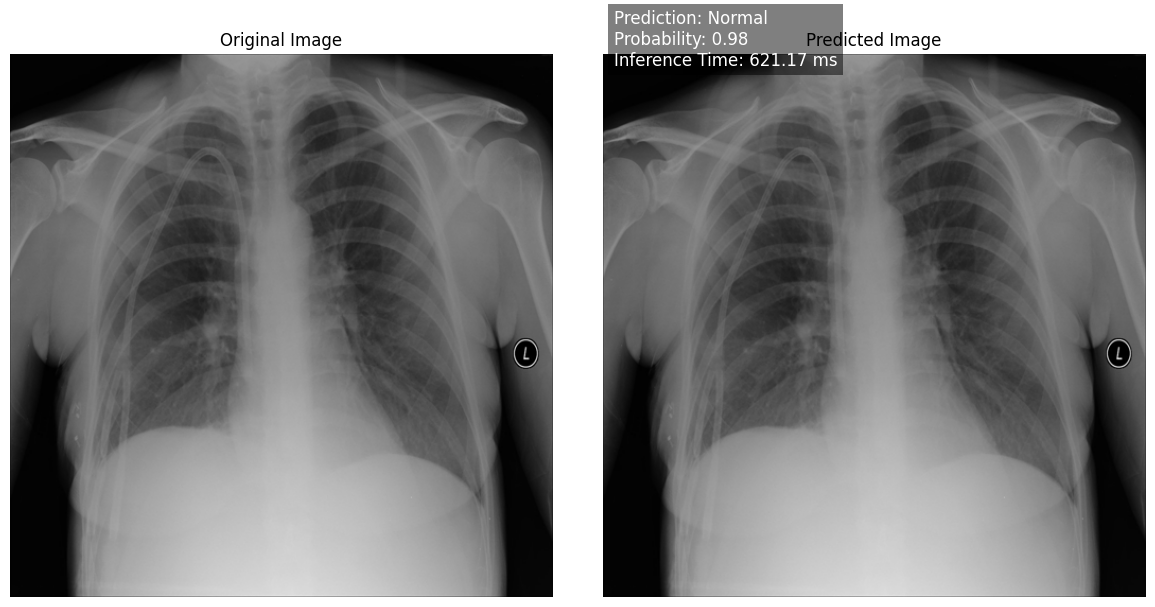

In [16]:
import os
import numpy as np
from PIL import Image
import mindspore as ms
from mindspore import load_checkpoint, load_param_into_net
import matplotlib.pyplot as plt
import time

def load_trained_model(model_path, num_classes=2):
    model = MobileNetV3(num_classes=num_classes) 
    param_dict = load_checkpoint(model_path)
    load_param_into_net(model, param_dict)
    model.set_train(False)
    return model

def preprocess_image(image_path, image_size=(512, 512)):
    # 打开图像并调整大小
    image = Image.open(image_path).convert("RGB")
    original_image = image.copy()  
    image = image.resize(image_size)
    # 转换为 NumPy 数组并归一化
    image = np.array(image).astype(np.float32)
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    image = (image - mean) / std
    # 转换为 CHW 格式
    image = np.transpose(image, (2, 0, 1))
    # 添加 batch 维度
    image = np.expand_dims(image, axis=0)
    # 转换为 MindSpore Tensor
    image = ms.Tensor(image, dtype=ms.float32)
    return image, original_image

# 推理函数
def predict(model, image_tensor):
    # 记录推理开始时间
    start_time = time.time()
    # 模型推理
    outputs = model(image_tensor)
    # 记录推理结束时间
    end_time = time.time()
    # 计算 softmax 概率
    probs = ms.ops.Softmax(axis=1)(outputs).asnumpy()
    # 获取预测类别
    pred_class = np.argmax(probs, axis=1)[0]
    # 计算推理时间（以毫秒为单位）
    inference_time = (end_time - start_time) * 1000  # 转换为毫秒
    return pred_class, probs[0], inference_time

if __name__ == "__main__":
    # 模型路径
    model_path = "best_model.ckpt"
    # 加载模型
    model = load_trained_model(model_path, num_classes=2)
    
    # 测试图像路径
    test_image_path = "./dataset/Normal/Normal-1.png" 
    if not os.path.exists(test_image_path):
        raise FileNotFoundError(f"测试图像文件 {test_image_path} 不存在！")
    
    # 预处理图像
    image_tensor, original_image = preprocess_image(test_image_path)
    
    # 进行预测
    pred_class, probs, inference_time = predict(model, image_tensor)
    
    # 输出结果
    class_names = ["Normal", "Tuberculosis"]  # 类别名称
    print(f"预测类别: {class_names[pred_class]}")
    print(f"类别概率: Normal: {probs[0]:.4f}, Tuberculosis: {probs[1]:.4f}")
    print(f"推理时间: {inference_time:.2f} ms")  # 打印推理时间
    
    # 使用 matplotlib 显示图像
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 创建两个子图
    
    # 显示原始图像
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")  # 关闭坐标轴
    
    # 显示预测图像
    predicted_image = np.array(original_image)  # 复制原始图像
    axes[1].imshow(predicted_image)
    axes[1].set_title("Predicted Image")
    axes[1].axis("off")  # 关闭坐标轴
    
    # 在预测图像上添加预测标签和推理时间
    label_text = (
        f"Prediction: {class_names[pred_class]}\n"
        f"Probability: {probs[pred_class]:.2f}\n"
        f"Inference Time: {inference_time:.2f} ms"
    )
    axes[1].text(
        10, 10, label_text, color="white", fontsize=12,
        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
    )
    
    # 显示图像
    plt.tight_layout()
    plt.show()